# Lab 1: NLP with The IMDB Reviews Dataset

In [ ]:
# get the data

import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMZ2ZJZ/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMZ2ZJZ/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMZ2ZJZ/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


info about the dataset

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpurmkyunitfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

look at the dataset. IMDB reviews dataset consists of train, test, and unspervised split

In [ ]:
print(imdb)

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


look at the first two examples of IMDB Reviews dataset. Each sample consists of two tuples: sentences and the labels

In [ ]:
for example in imdb['train'].take(2):
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

the data is in shape of tensor numpy and the sentence is in binary format. So, let's process and parse the data

In [ ]:
import numpy as np

training_sentences = []
testing_sentences = []
training_labels = []
testing_labels = []

for train_data in imdb['train']:
  training_sentences.append(train_data[0].numpy().decode('utf-8'))
  training_labels.append(train_data[1].numpy())

for test_data in imdb['test']:
  testing_sentences.append(test_data[0].numpy().decode('utf-8'))
  testing_labels.append(test_data[1].numpy())

final_training_labels = np.array(training_labels)
final_testing_labels = np.array(testing_labels)

the data already set up. then, start prepare the tokenizer

In [ ]:
vocab_size = 10000
max_length = 120
embedding_dim = 16
oov_tok = "<OOV>"

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, padding='post', truncating = 'post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, padding='post', truncating='post', maxlen=max_length)

After tokenizer done prepared, Then let's create the NLP model. The data has two labels: 0 and 1

input_dim is the size of vocabulary, while output_dim is embedding dim

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(6, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 11526     
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(padded, final_training_labels, epochs=10, validation_data=(testing_padded, final_testing_labels))

Epoch 1/10
782/782 [==============================] - 7s 7ms/step - loss: 0.5745 - accuracy: 0.7108 - val_loss: 0.4773 - val_accuracy: 0.8124
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3405 - accuracy: 0.8968 - val_loss: 0.4494 - val_accuracy: 0.8168
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1814 - accuracy: 0.9637 - val_loss: 0.4934 - val_accuracy: 0.8110
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1078 - accuracy: 0.9831 - val_loss: 0.5430 - val_accuracy: 0.8089
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0772 - accuracy: 0.9878 - val_loss: 0.5698 - val_accuracy: 0.8085
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0627 - accuracy: 0.9894 - val_loss: 0.6147 - val_accuracy: 0.8079
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0561 - accuracy: 0.9896 - val_loss: 0.6672 - val_accuracy: 0.8103
Epoch 

# Lab 2: Training a binary classifier with the Sarcasm **Dataset**

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-10-22 07:32:56--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2023-10-22 07:32:56 (150 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [ ]:
import json

with open("./sarcasm.json") as f:
  datastore = json.load(f)

In [ ]:
print(f"First line look like this \n{datastore[0]}")
print(f'\nTotal of data: {len(datastore)}')

First line look like this 
{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}

Total of data: 26709


In [ ]:
urls = []
sentences = []
labels = []

for item in datastore:
  urls.append(item['article_link'])
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [ ]:
#parameter
training_size = 20000
vocab_size = 10000
max_length = 32
embedding_dim = 16

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy

padding_type="post"
truncating_type = "post"
oov_tok = "<OOV>"

# split the data
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)

# label is number and need to be converted to numpy array
training_labels = numpy.array(training_labels)
testing_labels = numpy.array(testing_labels)

Here, the model uses GlobalAveragePooling1D instead of Flatten to have smaller parameters

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels))

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.5633 - accuracy: 0.6967 - val_loss: 0.4010 - val_accuracy: 0.8375
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3110 - accuracy: 0.8755 - val_loss: 0.3439 - val_accuracy: 0.8554
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2295 - accuracy: 0.9123 - val_loss: 0.3473 - val_accuracy: 0.8527
Epoch 4/30
625/625 [==============================] - 4s 6ms/step - loss: 0.1836 - accuracy: 0.9319 - val_loss: 0.3692 - val_accuracy: 0.8509
Epoch 5/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1517 - accuracy: 0.9439 - val_loss: 0.3992 - val_accuracy: 0.8498
Epoch 6/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1272 - accuracy: 0.9546 - val_loss: 0.4370 - val_accuracy: 0.8460
Epoch 7/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1088 - accuracy: 0.9628 - val_loss: 0.4925 - val_accuracy: 0.8368
Epoch 

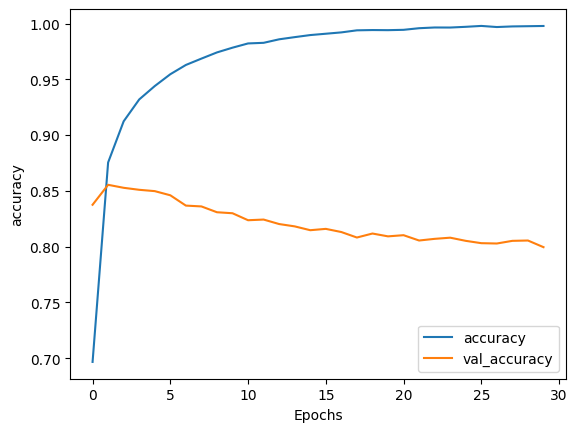

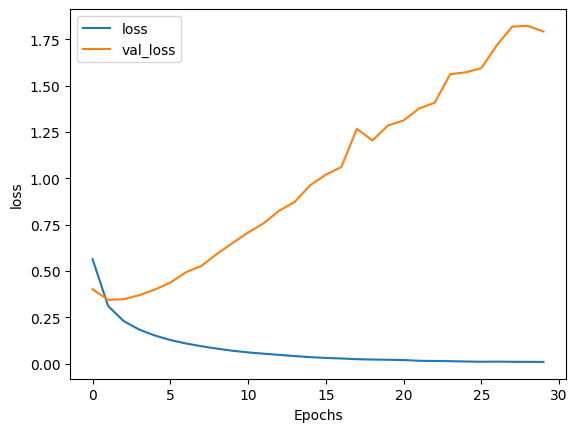

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Lab 3: Subwords Tokenization with The IMDB Reviews Dataset

In [ ]:
# get the data
import tensorflow_datasets as tfds

# imdb data in real sentence
imdb_plaintext, info_plaintext = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# imdb dataset as subword tokenized sequence
imdb_subwords, info_subwords = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)


In [ ]:
print(info_plaintext.features)

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})


In [ ]:
# look at the first two samples of imdb plain

for example in imdb_plaintext['train'].take(2):
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

In [ ]:
print(info_subwords.features)

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})


In [ ]:
# look at the first two samples of imdb plain

for example in imdb_subwords['train'].take(2):
  print(example)

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

so let's compare both tokenizer

In [ ]:
# generate training data first

training_sentences = []

for s, _ in imdb_plaintext['train']:
  training_sentences.append(s.numpy().decode('utf8'))


In [ ]:
# look at the performance of plain tokenizer on the first training data

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_plaintext = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_plaintext.fit_on_texts(training_sentences)

sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)
tokenizer_plaintext.sequences_to_texts(sequences[:1])


["this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it"]

In [ ]:
tokenizer_subwords = info_subwords.features['text'].encoder

sequences = tokenizer_subwords.encode(training_sentences[0])
print(f"Tokenized sequence: \n {sequences}")
original_text = tokenizer_subwords.decode(sequences)
print(f"Original text:\n {original_text}")

Tokenized sequence: 
 [62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975]
Original text:
 This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history

it shows that tokenizer_subwords works better than tokenizer_plaintext. Tokenizer_subwords based on sub-words look like below

In [ ]:
print(tokenizer_subwords.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

Tokenizer_subowrds also work better on unrecognized words

In [ ]:
sample_sentence = "Karisa is super COOL"

tokenized_string = tokenizer_plaintext.texts_to_sequences([sample_sentence])
print(f'Tokenized sequence: {tokenized_string}')

original_text = tokenizer_plaintext.sequences_to_texts(tokenized_string)
print(f'Original text: {original_text}')

Tokenized sequence: [[1, 7, 1163, 645]]
Original text: ['<OOV> is super cool']


In [ ]:
sample_sentence = "Karisa is super COOL"

tokenized_string = tokenizer_subwords.encode(sample_sentence)
print(f'Tokenized sequence: {tokenized_string}')

original_text = tokenizer_subwords.decode(tokenized_string)
print(f'Original text: {original_text}')

Tokenized sequence: [3430, 4721, 7961, 9, 5807, 2341, 8008, 8005]
Original text: Karisa is super COOL


In [ ]:
for ts in tokenized_string:
  print(f'{ts} --> {tokenizer_subwords.decode([ts])}')

3430 --> Kar
4721 --> isa
7961 -->  
9 --> is 
5807 --> super 
2341 --> CO
8008 --> O
8005 --> L


then, prepare the data and create the model

In [ ]:
buffer_size = 10000
batch_size = 64

training_data = imdb_subwords['train']
testing_data = imdb_subwords['test']

training_dataset = training_data.shuffle(buffer_size)

training_dataset = training_dataset.padded_batch(batch_size)
testing_dataset = testing_data.padded_batch(batch_size)

In [ ]:
import tensorflow as tf

embedding_dim = 64

model = tf.keras.Sequential([tf.keras.layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 524237 (2.00 MB)
Trainable params: 524237 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(training_dataset, epochs=10, validation_data=testing_dataset)

Epoch 1/10
391/391 [==============================] - 87s 209ms/step - loss: 0.6819 - accuracy: 0.5743 - val_loss: 0.6482 - val_accuracy: 0.7183
Epoch 2/10
391/391 [==============================] - 55s 141ms/step - loss: 0.5622 - accuracy: 0.7793 - val_loss: 0.4589 - val_accuracy: 0.8433
Epoch 3/10
391/391 [==============================] - 35s 90ms/step - loss: 0.3685 - accuracy: 0.8747 - val_loss: 0.3591 - val_accuracy: 0.8585
Epoch 4/10
391/391 [==============================] - 29s 74ms/step - loss: 0.2902 - accuracy: 0.8980 - val_loss: 0.3261 - val_accuracy: 0.8735
Epoch 5/10
391/391 [==============================] - 20s 51ms/step - loss: 0.2532 - accuracy: 0.9099 - val_loss: 0.3095 - val_accuracy: 0.8794
Epoch 6/10
391/391 [==============================] - 18s 44ms/step - loss: 0.2268 - accuracy: 0.9195 - val_loss: 0.3045 - val_accuracy: 0.8812
Epoch 7/10
391/391 [==============================] - 13s 31ms/step - loss: 0.2085 - accuracy: 0.9255 - val_loss: 0.3104 - val_accurac

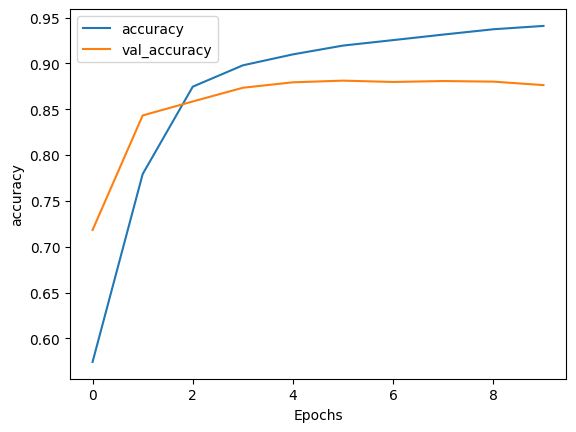

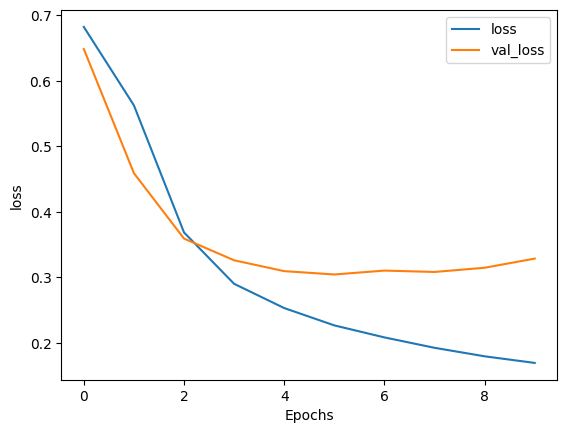

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Assignment C3 W2

In [ ]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
with open('./bbc-text.csv') as csvfile:
  print(f'first line look like this \n{csvfile.readline()}')
  print(f'each subsequent line look like this \n\n{csvfile.readline()}')

first line look like this 
category,text

each subsequent line look like this 

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the t

set the parameter

In [ ]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN ="<OOV>"
TRAINING_SPLIT = .8

In [ ]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [ ]:
sentences, labels = parse_data_from_file('./bbc-text.csv')

In [ ]:
train_size = int(TRAINING_SPLIT * len(sentences))

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

val_sentences = sentences[train_size:]
val_labels = labels[train_size:]

so let's create tokenizer both for sentences and labels

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_seq = pad_sequences(train_sequences, padding=PADDING, maxlen=MAXLEN)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
padded_val_seq = pad_sequences(val_sequences, padding=PADDING, maxlen=MAXLEN)

In [ ]:
label_tokenizer = Tokenizer()

label_tokenizer.fit_on_texts(labels)

train_labels_seq = label_tokenizer.texts_to_sequences(train_labels)
val_labels_seq = label_tokenizer.texts_to_sequences(val_labels)

#reduced by 1 because model treat neuron class output starts from zero
train_labels_seq = np.array(train_labels_seq) - 1
val_labels_seq = np.array(val_labels_seq) - 1

In [ ]:
print(f'classes: {set(labels)}')

classes: {'entertainment', 'tech', 'sport', 'business', 'politics'}


There are 5 classes used here

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(5, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 5)                 35        
                                                                 
Total params: 16137 (63.04 KB)
Trainable params: 16137 (63.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(padded_train_seq, train_labels_seq, epochs=30, validation_data=(padded_val_seq, val_labels_seq))

Epoch 1/30
56/56 [==============================] - 8s 133ms/step - loss: 1.6004 - accuracy: 0.3039 - val_loss: 1.5905 - val_accuracy: 0.3258
Epoch 2/30
56/56 [==============================] - 3s 59ms/step - loss: 1.5732 - accuracy: 0.3208 - val_loss: 1.5563 - val_accuracy: 0.3303
Epoch 3/30
56/56 [==============================] - 2s 36ms/step - loss: 1.5253 - accuracy: 0.3854 - val_loss: 1.5004 - val_accuracy: 0.3865
Epoch 4/30
56/56 [==============================] - 1s 12ms/step - loss: 1.4529 - accuracy: 0.4236 - val_loss: 1.4225 - val_accuracy: 0.4247
Epoch 5/30
56/56 [==============================] - 1s 23ms/step - loss: 1.3546 - accuracy: 0.5185 - val_loss: 1.3222 - val_accuracy: 0.5213
Epoch 6/30
56/56 [==============================] - 1s 18ms/step - loss: 1.2381 - accuracy: 0.6264 - val_loss: 1.2144 - val_accuracy: 0.5640
Epoch 7/30
56/56 [==============================] - 1s 18ms/step - loss: 1.1157 - accuracy: 0.6803 - val_loss: 1.0993 - val_accuracy: 0.6494
Epoch 8/30
5

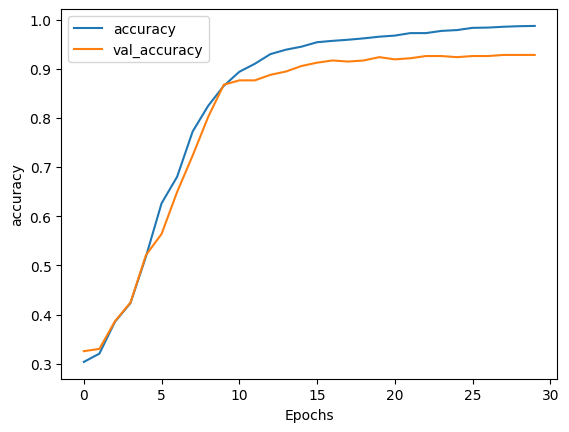

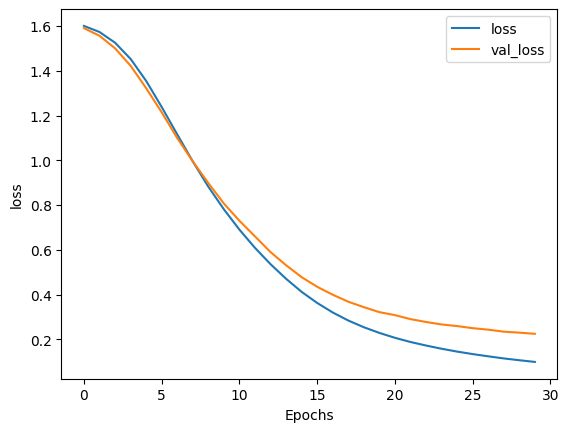

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")